In [1]:
import mlflow
import lightning as L
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

from multimodal_bridge_matching import MultiModalBridgeMatching, HybridState
from data.particle_clouds.jets import JetDataclass
from data.particle_clouds.particles import ParticleClouds

from utils.configs import get_run_info
from utils.dataloader import DataloaderModule
from utils.callbacks import JetsGenerativeCallback


######################################################################################
experiment_name = "multimodal_bridge_aoj"
run_name = "overjoyed-owl-404"
ckpt = "last.ckpt"
######################################################################################

#...mlflow setup

mlflow.set_tracking_uri("/home/df630/Multimodal-Bridges/experiments/results/mlruns")
run_id, artifact_dir = get_run_info(experiment_name=experiment_name, run_name=run_name)
print(f"Run ID: {run_id}")

bridge = MultiModalBridgeMatching.load_from_checkpoint(artifact_dir / 'checkpoints' / ckpt)
config = bridge.config

#...callbacks:

progress_bar = RichProgressBar(theme=RichProgressBarTheme(**config.experiment.progress_bar.to_dict()))
generative_callback = JetsGenerativeCallback(config.clone()) 

#...modify configs (always after callbacks)

config.data.target.path = "/home/df630/CMB/data/AOJ/2016H_job9.h5"
config.data.target.delete("preprocess")
config.data.target.params.num_jets = 3000
config.train.batch_size = 128
config.train.data_split_frac = [0.0, 0.0, 1.0]


Run ID: b91f479e50ea423fa625df1b9644b2ec


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [2]:
#...prep test data 

jets = JetDataclass(config=config)
jets.preprocess()
dataloader = DataloaderModule(config=config, dataclass=jets)

#...lightning model

generator = L.Trainer(
    log_every_n_steps=5,
    accelerator="gpu",
    devices=[0],
    callbacks=[progress_bar, generative_callback],
    logger=False,
)

#...generate data

generator.predict(bridge, dataloaders=dataloader.test)

/home/df630/Multimodal-Bridges/multimodal_bridges/data/particle_clouds/utils.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.0/0.0/1.0
INFO: train size: 0, validation size: 0, testing sizes: 3000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Output()

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Clustering jets with fastjet

Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination

UserWarning: dcut and exclusive jets for jet-finders other than kt, C/A or genkt with p>=0 should be interpreted 
with care.

Calculating N-subjettiness

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Calculating D2

Clustering jets with fastjet

Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination

Calculating N-subjettiness

Calculating D2

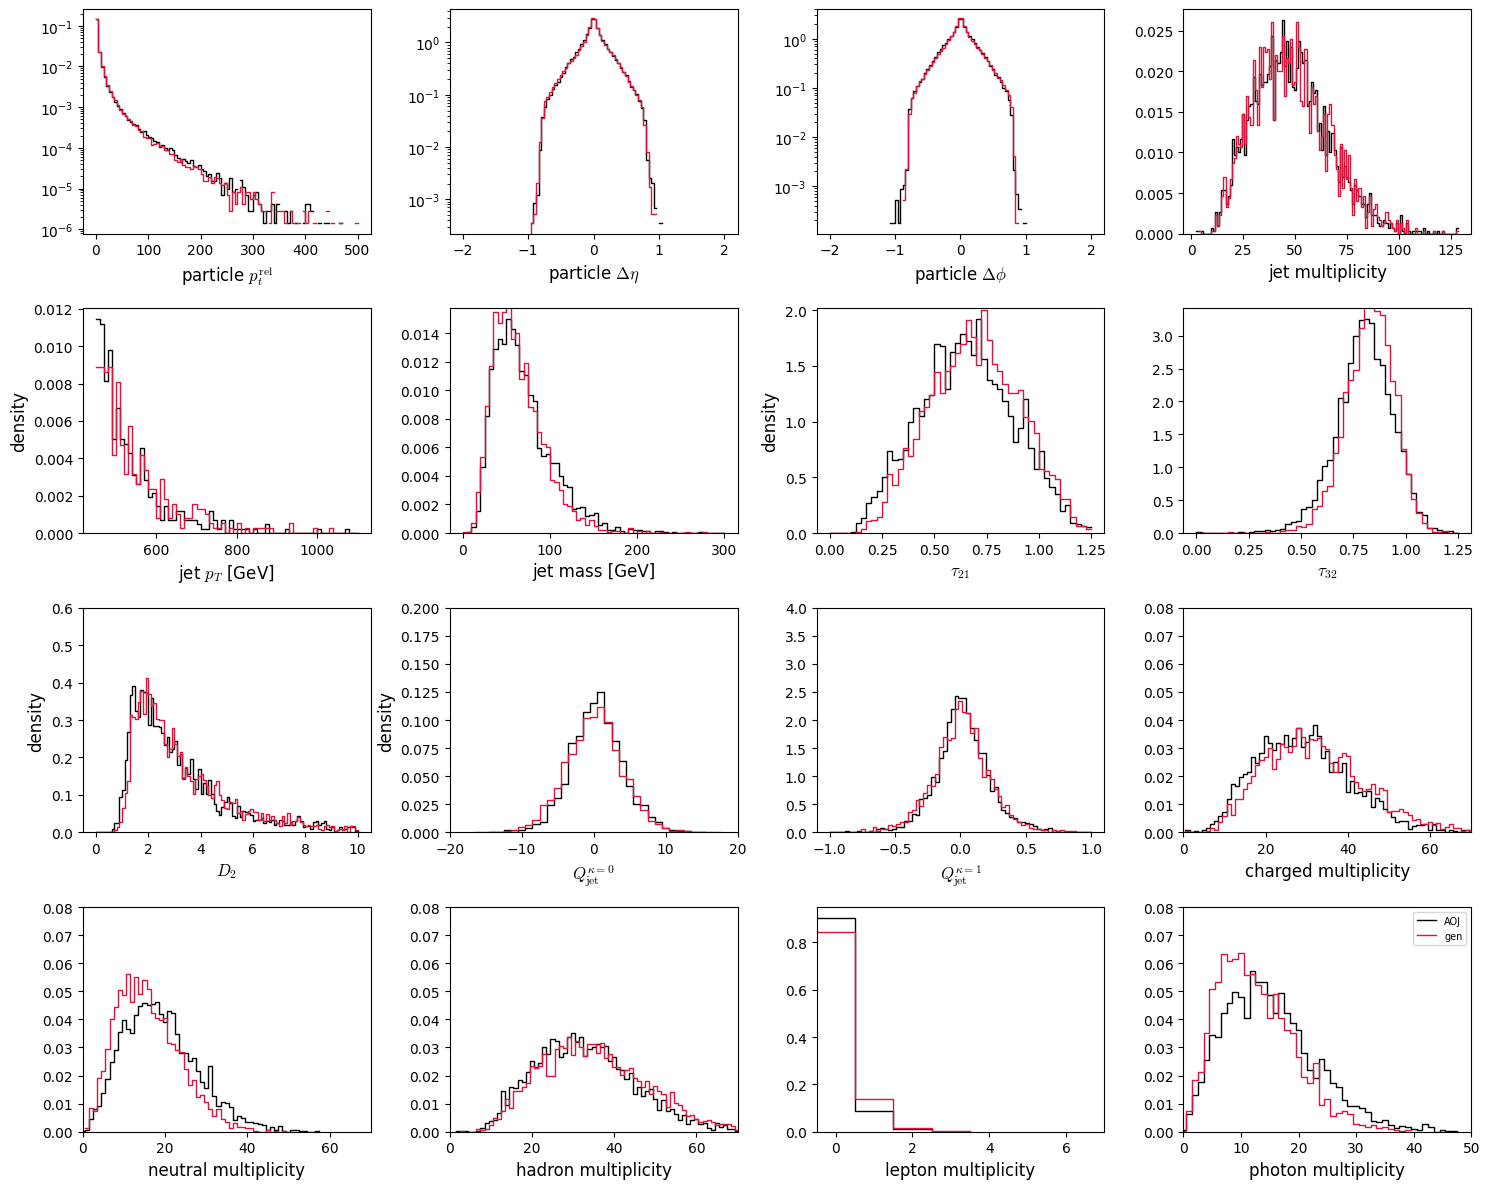

[(HybridState(time=tensor([[0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
          [0.9999],
   

In [3]:
#...generate data
sample = generator.predict(bridge, dataloaders=dataloader.test)